# Plot correspondences in registration

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import ipywidgets as ipyw
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

from otimage import imagerep, io
from otimage.utils import plot_maxproj
from otimage.imagereg import ot_registration, gw_registration

## Load Zimmer data

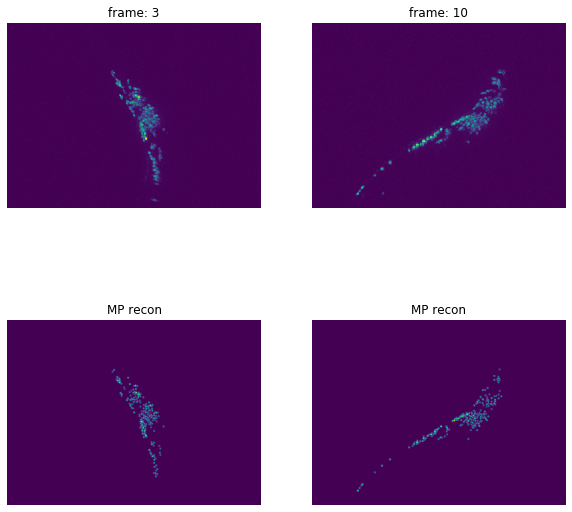

In [3]:
# Frame index
t1 = 3
t2 = 10

# Load two successive frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with io.ZimmerReader(img_path) as reader:
    img_1 = reader.get_frame(t1)
    img_2 = reader.get_frame(t2)
    img_shape = img_1.shape

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.mat'
with io.MPReader(mp_path) as reader:
    mp_1 = reader.get_frame(t1)
    mp_2 = reader.get_frame(t2)

# Reconstruct images from MPs
rec_1 = imagerep.reconstruct_mp_image(mp_1)
rec_2 = imagerep.reconstruct_mp_image(mp_2)
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj(img_1)
plt.title(f'frame: {t1}')
plt.axis('off')

plt.subplot(222)
plot_maxproj(img_2)
plt.title(f'frame: {t2}')
plt.axis('off');

plt.subplot(223)
plot_maxproj(rec_1)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj(rec_2)
plt.title('MP recon')
plt.axis('off');

## Compute registration for images

In [4]:
degree = 2
n_iter = 50

model, debug = gw_registration(mp_1, mp_2, degree=degree, n_iter=n_iter)

print('beta (est):')
print(model.beta)

beta (est):
[[-9.62683387e+03  2.66725484e+01  1.95223577e+01  3.82051406e+01
  -1.78139933e-02 -2.55387295e-02 -4.86759722e-02 -8.28495525e-03
  -5.00787883e-02  8.25187410e-02]
 [-1.26367789e+04  3.50441421e+01  2.48260575e+01  6.44354105e+01
  -2.32195307e-02 -3.56446864e-02 -8.76082652e-02 -9.97213003e-03
  -5.77009369e-02 -1.03065103e-01]
 [ 2.84971843e+02 -5.41247298e-01 -6.73355460e-01 -2.18610730e+00
   2.01124674e-04  8.27840790e-04  2.25317400e-03  3.22913555e-04
   3.06990711e-03  4.91134275e-03]]


## Compute pushforward with identified MP component

In [5]:
# Transform MP points for first image using mapping
pf_pts = model.predict(mp_1.pts).astype(int)

## Plot color-coded correspondence

In [6]:
def get_mp_colors(pts):
     
    colors_sorted = cm.rainbow(np.linspace(0, 1, pts.shape[0]))
    sort_idx = np.lexsort((pts[:, 0], pts[:, 1]))
    unsort_idx = np.argsort(sort_idx)
    
    return colors_sorted[unsort_idx]

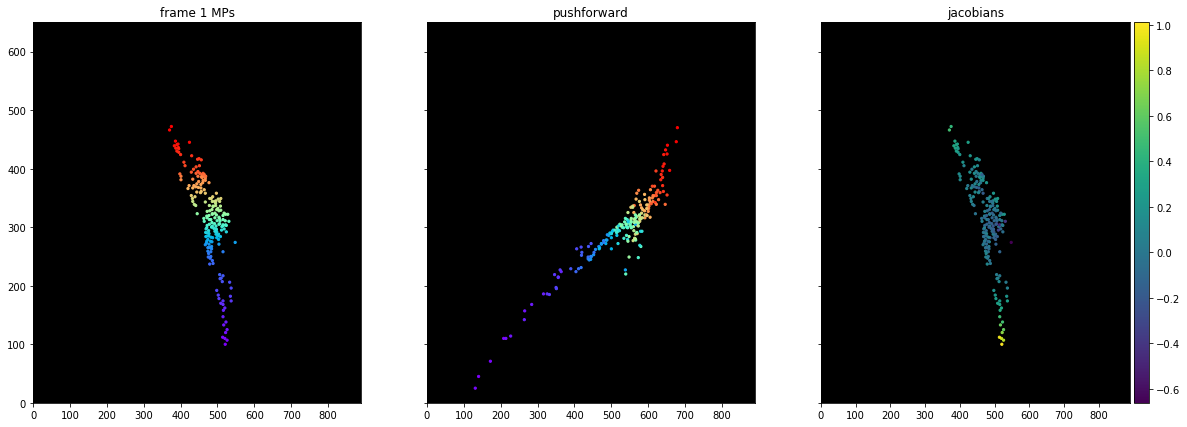

In [7]:
# Use lexical sorting to assign colors to points
mp_colors = get_mp_colors(mp_1.pts)

# Compute Jacobian determinants at MP points
jac_dets = model.det_jac(mp_1.pts).flatten()

# Plot MPs from frame 1 and their pushforwards
subplot_kw = {
    'facecolor': 'black',
    'xlim': [0, img_shape[0]],
    'ylim': [0, img_shape[1]],
}
fig, (ax_1, ax_2, ax_3) = plt.subplots(
    1, 3, sharex=True, sharey=True, subplot_kw=subplot_kw, figsize=(20, 7))

ax_1.set_title('frame 1 MPs')
ax_1.scatter(mp_1.pts[:, 0], mp_1.pts[:, 1], s=5, c=mp_colors)

ax_2.set_title('pushforward')
ax_2.scatter(pf_pts[:, 0], pf_pts[:, 1], s=5, c=mp_colors)
    
ax_3.set_title('jacobians')
im_3 = ax_3.scatter(mp_1.pts[:, 0], mp_1.pts[:, 1], s=5, c=jac_dets)
div_3 = make_axes_locatable(ax_3)
cax_3 = div_3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im_3, cax=cax_3, orientation='vertical');